### Hidden Correlation Analysis Tutorial

This tutorial demonstrates how our synthetic data generation tool preserves hidden correlations in a **star schema**. The **Players** table serves as the central entity, linking the **Batting** and **Fielding** tables through the foreign key `players_id`. While these tables are not directly connected, they share implicit relationships through common attributes such as player, year, and team.

In this tutorial, we will:
1. Analyze the correlation between **Batting** and **Fielding** statistics in the original dataset.
2. Train a synthetic data generator using the three related tables: **Players, Batting, and Fielding**.
3. Demonstrate that training the generator with both related tables together allows it to **implicitly retain correlations** between them, even though they are not directly linked.

This approach highlights how our tool **maintains data consistency across related tables**, ensuring synthetic data preserves meaningful statistical relationships.

<img src='https://raw.githubusercontent.com/mostly-ai/mostly-tutorials/dev/hidden_correlations/baseball_table_relationships.png' width="600px"/>


In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

### Step 1: Load and Filter the Data

We begin by loading the datasets. The **Players** table serves as the **central entity**, linking the **Batting** and **Fielding** tables through the foreign key `players_id`. These tables contain player performance statistics.

To ensure that our analysis focuses on **modern-era players**, we filter the data to retain only players who **played exclusively after 1945**. This ensures that no player with pre-1945 data is included, keeping the dataset relevant for analysis.


In [2]:
import pandas as pd

# Load the datasets
players_url = "https://github.com/mostly-ai/public-demo-data/raw/refs/heads/dev/baseball/players.csv.gz"
batting_url = "https://github.com/mostly-ai/public-demo-data/raw/refs/heads/dev/baseball/batting.csv.gz"
fielding_url = "https://github.com/mostly-ai/public-demo-data/raw/refs/heads/dev/baseball/fielding.csv.gz"

players_original = pd.read_csv(players_url, compression='gzip', low_memory=False)
batting_original = pd.read_csv(batting_url, compression='gzip', low_memory=False)
fielding_original = pd.read_csv(fielding_url, compression='gzip', low_memory=False)

# Filter data first, keeping only records from post-1945
batting_filtered = batting_original[batting_original['year'] > 1945]
fielding_filtered = fielding_original[fielding_original['year'] > 1945]

# Identify players who played only after 1945
valid_batting_players = batting_filtered.groupby('players_id')['year'].min() > 1945
valid_fielding_players = fielding_filtered.groupby('players_id')['year'].min() > 1945

# Find common players
valid_players = valid_batting_players.index.intersection(valid_fielding_players.index)

# Filter all datasets
players_df = players_original[players_original['id'].isin(valid_players)]
batting_df = batting_filtered[batting_filtered['players_id'].isin(valid_players)]
fielding_df = fielding_filtered[fielding_filtered['players_id'].isin(valid_players)]

# Display the filtered datasets
players_df.head(), batting_df.head(), fielding_df.head()


(          id country   birthDate   deathDate nameFirst nameLast  weight  \
 0  aardsda01     USA  1981-12-27         NaN     David  Aardsma   215.0   
 1  aaronha01     USA  1934-02-05         NaN      Hank    Aaron   180.0   
 2  aaronto01     USA  1939-08-05  1984-08-16    Tommie    Aaron   190.0   
 3   aasedo01     USA  1954-09-08         NaN       Don     Aase   190.0   
 4   abadan01     USA  1972-08-25         NaN      Andy     Abad   184.0   
 
    height bats throws  
 0    75.0    R      R  
 1    72.0    R      R  
 2    75.0    R      R  
 3    75.0    R      R  
 4    73.0    L      L  ,
       players_id  year team league   G   AB   R   H  HR   RBI    SB   CS  BB  \
 32067  abernwo01  1946  NY1     NL  15    8   0   0   0   0.0   0.0  NaN   0   
 32068  adamsac01  1946  NY1     NL   3    0   0   0   0   0.0   0.0  0.0   0   
 32069  adamsbo03  1946  CIN     NL  94  311  35  76   4  24.0  16.0  NaN  18   
 32070  adamsbu01  1946  SLN     NL  81  173  21  32   5  22.0   3.

### Step 2: Merge the Tables

To analyze correlations, we merge the **Batting** and **Fielding** tables using the **Players** table as a bridge. Since **batting and fielding are not directly related**, we connect them through their common attributes: `players_id`, `year`, and `team`.

- First, we merge **batting statistics** with player details.
- Next, we **aggregate fielding statistics**, summing numeric columns (excluding categorical fields).
- Finally, we merge **batting and fielding data** using an **outer join**, ensuring that all records are retained even if some statistics are missing.
- Missing numerical values from the **outer join** are set to **0** to maintain data consistency.


In [3]:
# Merge batting data with player details
batting_with_players = pd.merge(
    batting_df, players_df, left_on='players_id', right_on='id', how='inner'
)

# Aggregate fielding statistics, summing only numeric columns
numeric_cols = fielding_df.select_dtypes(include=['number']).columns.difference(['players_id', 'year', 'team'])
fielding_agg = fielding_df.groupby(['players_id', 'year', 'team'])[numeric_cols].sum().reset_index()

# Merge batting and fielding data using an outer join
batting_fielding = pd.merge(
    batting_with_players, fielding_agg, on=['players_id', 'year', 'team'], how='outer'
)

# Get the actual numeric columns that exist in batting_fielding after merging
existing_numeric_cols = batting_fielding.select_dtypes(include=['number']).columns

# Set NaN numerical values to 0 only for existing columns
batting_fielding[existing_numeric_cols] = batting_fielding[existing_numeric_cols].fillna(0)

# Display merged table
print("\nCombined Batting and Fielding:")
print(batting_fielding.head())



Combined Batting and Fielding:
  players_id  year team league  G_x  AB  R  H  HR  RBI  ...  height  bats  \
0  aardsda01  2004  SFN     NL   11   0  0  0   0  0.0  ...    75.0     R   
1  aardsda01  2006  CHN     NL   45   2  0  0   0  0.0  ...    75.0     R   
2  aardsda01  2007  CHA     AL   25   0  0  0   0  0.0  ...    75.0     R   
3  aardsda01  2008  BOS     AL   47   1  0  0   0  0.0  ...    75.0     R   
4  aardsda01  2009  SEA     AL   73   0  0  0   0  0.0  ...    75.0     R   

   throws    A   DP    E   G_y   GS InnOuts   PO  
0       R  0.0  0.0  0.0  11.0  0.0    32.0  0.0  
1       R  5.0  1.0  0.0  45.0  0.0   159.0  1.0  
2       R  4.0  0.0  1.0  25.0  0.0    97.0  2.0  
3       R  6.0  0.0  0.0  47.0  0.0   146.0  3.0  
4       R  5.0  1.0  0.0  73.0  0.0   214.0  2.0  

[5 rows x 31 columns]


### Step 3: Correlation Analysis

With the merged dataset, we compute the correlation matrix to analyze relationships between **Batting** and **Fielding** statistics. This helps us understand whether certain performance metrics are inherently related in the original data.

#### Key Steps:
1. Reorder the columns to separate **player information**, **batting statistics**, and **fielding statistics**.
2. Select **only numeric columns** for correlation analysis.
3. Compute and visualize the **correlation matrix** using a heatmap.
4. Add visual separators to distinguish correlations **within** and **between** batting and fielding features.


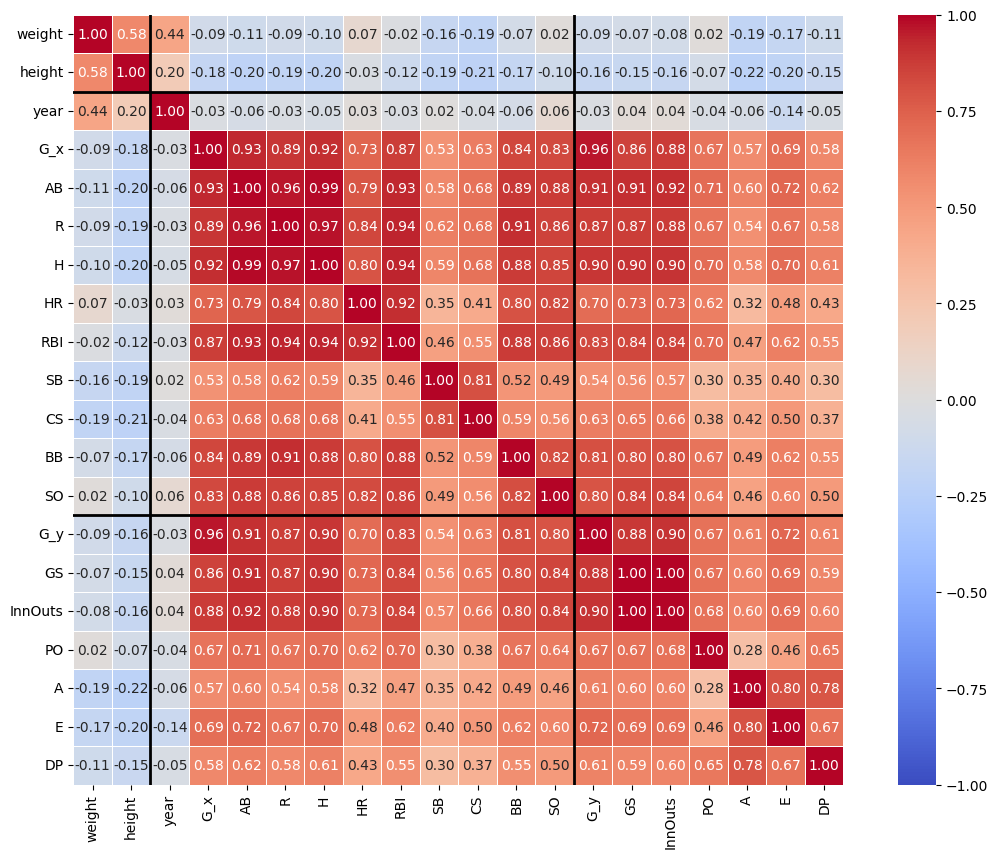

In [4]:
# Reorder columns: players, then batting, then fielding
ordered_columns = ['id', 'country', 'birthDate', 'deathDate', 'nameFirst', 'nameLast', 'weight', 'height', 'bats', 'throws',
                   'year', 'team', 'league', 'G_x', 'AB', 'R', 'H', 'HR', 'RBI', 'SB', 'CS', 'BB', 'SO',
                   'G_y', 'GS', 'InnOuts', 'PO', 'A', 'E', 'DP']

# Ensure the columns are in the correct order
batting_fielding_ordered = batting_fielding[ordered_columns]

# Select only numeric columns for correlation
numeric_columns = batting_fielding_ordered.select_dtypes(include=['float64', 'int64']).columns
corr_matrix = batting_fielding_ordered[numeric_columns].corr()

# Plot the correlation matrix with values
plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True, linewidths=0.5, vmin=-1, vmax=1)

# Add lines to separate the original tables
plt.axvline(x=2, color='black', linewidth=2)  # After players columns
plt.axvline(x=13, color='black', linewidth=2)  # After batting columns
plt.axhline(y=2, color='black', linewidth=2)  # After players columns
plt.axhline(y=13, color='black', linewidth=2)  # After batting columns
plt.show()# Select only numeric columns and fill NaNs with 0
numeric_columns = batting_fielding_ordered.select_dtypes(include=['float64', 'int64']).columns

# Fill NaN values in numeric columns explicitly using .loc
batting_fielding_ordered.loc[:, numeric_columns] = batting_fielding_ordered[numeric_columns].fillna(0)

# Compute correlation matrix
corr_matrix = batting_fielding_ordered[numeric_columns].corr()

### Step 4: Batting vs. Fielding Correlation Analysis

Now that we have computed the full correlation matrix, we focus specifically on **the relationships between batting and fielding statistics**. Since the **Batting** and **Fielding** tables are not directly connected but share common attributes (`players_id`, `year`, `team`), this step helps us observe how performance in one area correlates with the other.

#### Key Steps:
1. **Select relevant columns** from the Batting and Fielding tables.
2. **Compute correlations** between each batting and fielding statistic.
3. **Visualize the correlation matrix** to highlight key relationships.

This analysis helps verify whether batting and fielding statistics exhibit meaningful correlations in the real dataset, which will later be compared with synthetic data to assess the preservation of hidden relationships.


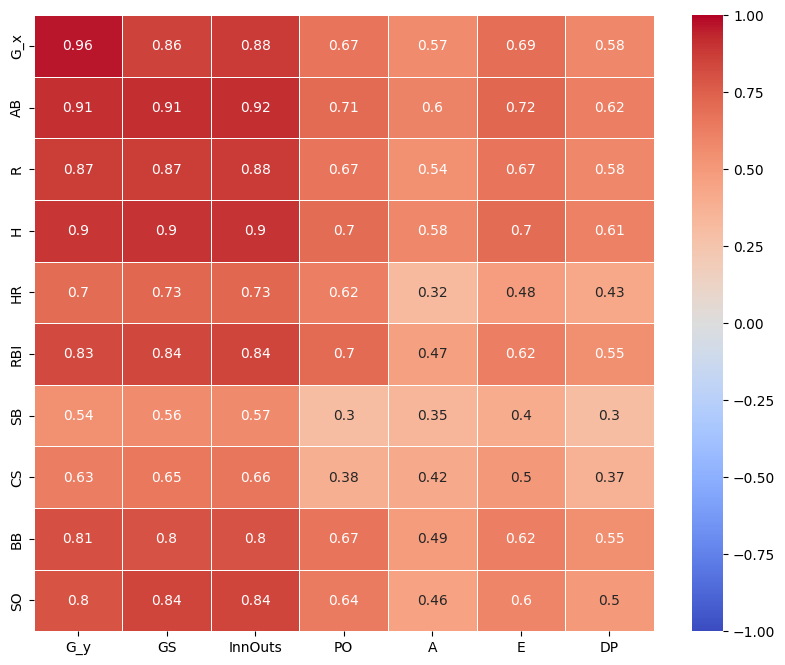

In [5]:
# Define the columns from the batting and fielding tables
batting_columns = ['G_x', 'AB', 'R', 'H', 'HR', 'RBI', 'SB', 'CS', 'BB', 'SO']
fielding_columns = ['G_y', 'GS', 'InnOuts', 'PO', 'A', 'E', 'DP']

# Create a DataFrame to store the correlation values
corr_df = pd.DataFrame(index=batting_columns, columns=fielding_columns)

# Calculate the correlation for each pair of columns
for b_col in batting_columns:
    for f_col in fielding_columns:
        corr_df.loc[b_col, f_col] = batting_fielding[b_col].corr(batting_fielding[f_col])

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_df.astype(float), annot=True, cmap='coolwarm', cbar=True, linewidths=0.5, vmin=-1, vmax=1)

plt.show()

### Step 5: Define Generator Configurations

Now that we have analyzed correlations in the real dataset, we define the generator configuration for training on both **Batting** and **Fielding** tables simultaneously. This setup enables the synthetic data generator to automatically learn and maintain correlations between the two related tables.

#### Key Configuration Details:
- **Players Table** acts as the central reference table, with `id` as its primary key.
- **Batting Table** and **Fielding Table** reference the `players_id` foreign key, establishing their connection to the **Players Table**.
- Both related tables are configured with `"is_context": True`, ensuring that player-level information is used when generating synthetic data.
- The generator is set with a maximum training time of **30 minutes** and **value protection disabled** for unrestricted data generation.

This step ensures that when synthetic data is generated, the correlations between **Batting** and **Fielding** statistics are preserved.


In [6]:
#!pip install -U 'mostlyai[local]'

In [7]:
from mostlyai.sdk import MostlyAI

# initialize SDK
mostly = MostlyAI(local=True)  # or: MostlyAI(base_url='xxx', api_key='xxx')

Starting Synthetic Data SDK in local mode using ]8;id=848058;file:///Users/marioscriminaci/mostlyai\file:///Users/marioscriminaci/mostlyai]8;;\

Connected to Synthetic Data SDK in local mode (4.1.1)

In [8]:
players_table_config = {
    "name": "players",
    "data": players_df,
    "tabular_model_configuration": {
        "max_training_time": 30,
        "value_protection": False,
        "enable_flexible_generation": False,
    },
    "primary_key": "id"
}

batting_table_config = {
    "name": "batting",
    "data": batting_df,
    "tabular_model_configuration": {
        "max_training_time": 30,
        "value_protection": False,
        "enable_flexible_generation": False,
    },
    "foreign_keys": [
        {
           "column": "players_id",
           "referenced_table": "players",
           "is_context": True
        }
    ]
}

fielding_table_config = {
    "name": "fielding",
    "data": fielding_df,
    "tabular_model_configuration": {
        "max_training_time": 30,
        "value_protection": False,
        "enable_flexible_generation": False,
    },
    "foreign_keys": [
        {
           "column": "players_id",
           "referenced_table": "players",
           "is_context": True
        }
    ]
}

generator_config = {
    "name": "Multi-table Correlation Tutorial - Baseball Player->Batting,Fielding Generator",
    "tables": [ players_table_config, batting_table_config, fielding_table_config ],
}

### Step 6: Training the Generators

After defining the generator configurations, we now proceed with training the synthetic data generator. This step enables the model to learn patterns and correlations from the **Players, Batting, and Fielding** tables, ensuring that the relationships observed in the real data are preserved in the generated synthetic data.

The generator will:
- Learn **player-specific** characteristics from the **Players** table.
- Capture **batting and fielding statistics** while maintaining their correlations through the shared **players_id** key.
- Automatically manage dependencies between **Batting** and **Fielding**, ensuring a realistic multi-table generation process.

Once the training process is complete, the generator will be ready to create synthetic datasets that retain the hidden correlations between these tables.


In [9]:
# training the full_generator
generator = mostly.train(config=generator_config)

Created generator 6084b878-3852-4aef-96de-5de7c7274b5d

Started generator training

Output()

🎉 Your generator is ready! Use it to create synthetic data. Publish it so others can do the same.

In [11]:
print(f'{generator.id} {generator.name} - {generator.accuracy}')

6084b878-3852-4aef-96de-5de7c7274b5d Multi-table Correlation Tutorial - Baseball Player->Batting,Fielding Generator - 0.957


### Step 7: Generate Synthetic Data Using the Original Players as Seed

To ensure a meaningful comparison between real and synthetic correlations, we generate **synthetic Batting and Fielding tables** while using the **original Players table as a seed**. This process, known as **conditional generation**, ensures that the synthetic data retains the same player distribution as the real dataset.

#### **Why Use the Original Players as Seed?**
- It guarantees that synthetic **batting and fielding statistics** are generated **for the same set of players** as in the real dataset.
- It allows for a **direct comparison** between the original and synthetic correlation matrices.

With this approach, we can later assess how well the synthetic dataset preserves the relationships between Batting and Fielding.


In [12]:
synthetic_dataset = mostly.generate(generator, seed={'players': players_df})

Created synthetic dataset 5ef38a68-c571-4cda-8c58-1509901eb3ee with generator 6084b878-3852-4aef-96de-5de7c7274b5d

Started synthetic dataset generation

Output()

🎉 Your synthetic dataset is ready! Use it to consume the generated data. Publish it so others can do the same.

### Step 8: Merging the Synthetic Batting and Fielding Tables

After generating synthetic data, we need to merge the **synthetic Batting and Fielding tables** in the same way as we did with the real data. This ensures that our synthetic dataset follows the same structure, allowing for a direct comparison of correlations.

#### Key Steps:
1. Extract **synthetic** Players, Batting, and Fielding tables from the generated dataset.
2. Merge **Batting** with **Players** using `players_id` as the foreign key.
3. Merge the resulting dataset with **Fielding**, using an **outer join** to retain all records.

By structuring the synthetic data identically to the real dataset, we can later perform a correlation analysis and assess how well the synthetic data preserves relationships between Batting and Fielding.


In [13]:
# Getting the dataframes from the synthetic dataset
players_df_syn = synthetic_dataset.data()['players'] # same as the seed used
batting_df_syn = synthetic_dataset.data()['batting']
fielding_df_syn = synthetic_dataset.data()['fielding']

# Merge sequence tables with the flat table
batting_with_players_syn = pd.merge(batting_df_syn, players_df_syn, left_on='players_id', right_on='id', how='inner')

# Join batting and fielding through the players table
batting_fielding_syn = pd.merge(batting_with_players_syn, fielding_df_syn, on=['players_id', 'year', 'team'], how='outer')

# Display merged tables
print("\nCombined Synthetic Batting and Fielding:")
print(batting_fielding_syn.head())


Combined Synthetic Batting and Fielding:
  players_id  year team league_x  G_x  AB   R   H  HR  RBI  ...  throws  \
0  aardsda01  2016  LAN       NL   35  64  11  10   2   12  ...       R   
1  aardsda01  2017  LAN       NL    5  17   2   5   0    1  ...       R   
2  aardsda01  2017  LAN       NL    5  17   2   5   0    1  ...       R   
3  aardsda01  2017  LAN       NL    1   2   0   0   0    0  ...       R   
4  aardsda01  2017  LAN       NL    1   2   0   0   0    0  ...       R   

   league_y  POS  G_y  GS InnOuts   PO   A  E  DP  
0        NL   1B   26  22     544  141  15  0  10  
1        NL   3B    1   0       3    0   1  0   0  
2        NL    C    8   4     106   29   2  0   0  
3        NL   3B    1   0       3    0   1  0   0  
4        NL    C    8   4     106   29   2  0   0  

[5 rows x 33 columns]


### Step 9: Comparing Correlations Between Real and Synthetic Data

Now that we have merged the synthetic **Batting** and **Fielding** tables, we analyze the correlation matrix for the synthetic dataset and compare it with the original data.

#### Key Steps:
1. **Compute the correlation matrix** for the synthetic dataset.
2. **Visualize the synthetic correlation matrix** to check if the statistical relationships between batting and fielding are maintained.
3. **Compare side-by-side** the zoomed-in correlation matrices between Batting and Fielding for both **real and synthetic data**.

This comparison helps us evaluate how well the generator preserved the **hidden correlations** in the synthetic dataset.


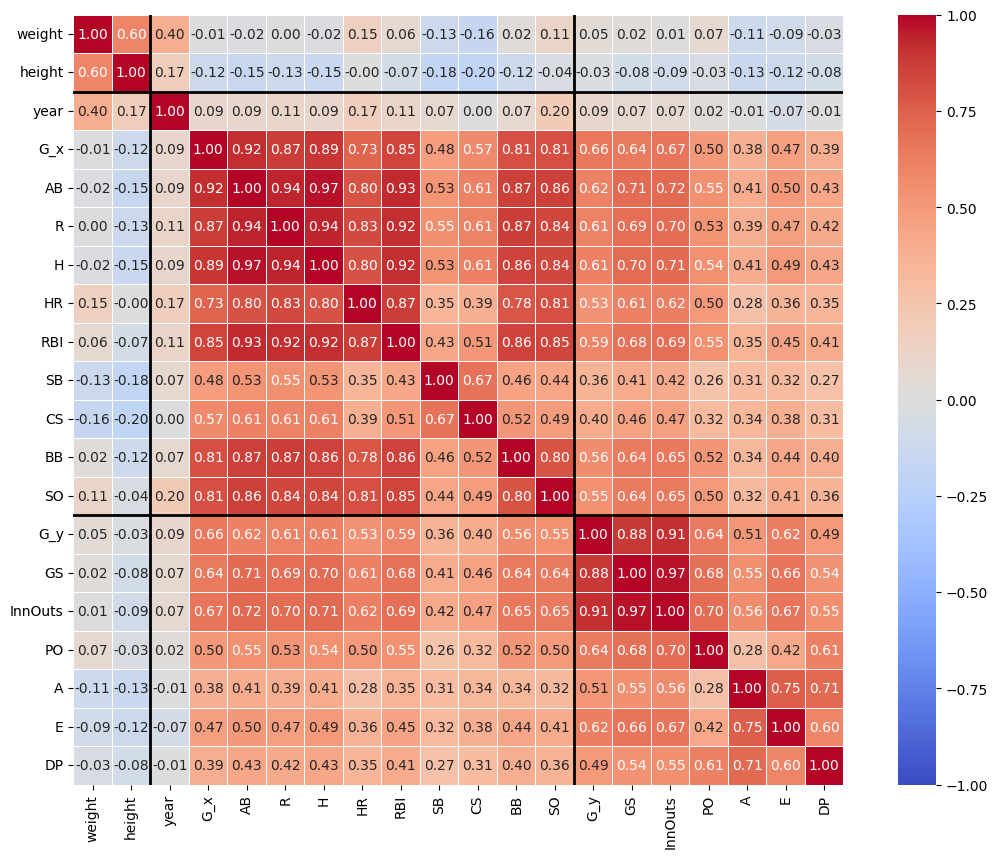

In [14]:
# Reorder columns: players, then batting, then fielding
ordered_columns = ['id', 'country', 'birthDate', 'deathDate', 'nameFirst', 'nameLast', 'weight', 'height', 'bats', 'throws',
                   'year', 'team', 'league_y', 'G_x', 'AB', 'R', 'H', 'HR', 'RBI', 'SB', 'CS', 'BB', 'SO',
                   'G_y', 'GS', 'InnOuts', 'PO', 'A', 'E', 'DP']

# Ensure the columns are in the correct order
batting_fielding_syn_ordered = batting_fielding_syn[ordered_columns]

# Select only numeric columns for correlation
numeric_columns = batting_fielding_syn_ordered.select_dtypes(include=['float64', 'int64']).columns
corr_matrix_syn = batting_fielding_syn_ordered[numeric_columns].corr()

# Plot the correlation matrix with values
plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix_syn, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True, linewidths=0.5, vmin=-1, vmax=1)

# Add lines to separate the original tables
plt.axvline(x=2, color='black', linewidth=2)  # After players columns
plt.axvline(x=13, color='black', linewidth=2)  # After batting columns
plt.axhline(y=2, color='black', linewidth=2)  # After players columns
plt.axhline(y=13, color='black', linewidth=2)  # After batting columns
plt.show()

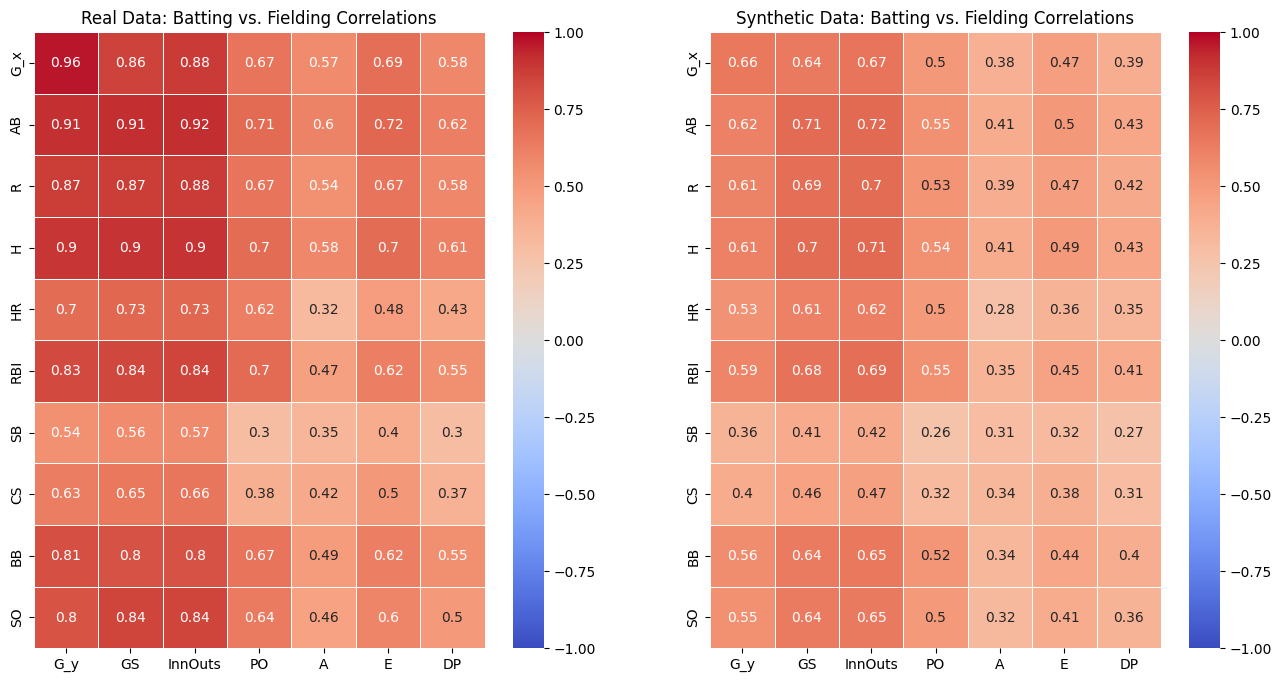

In [15]:
# Extract only Batting vs. Fielding correlations for both real and synthetic data
corr_df_real = corr_matrix.loc[batting_columns, fielding_columns]
corr_df_syn = corr_matrix_syn.loc[batting_columns, fielding_columns]

# Create a side-by-side plot
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Plot real data correlations
sns.heatmap(corr_df_real.astype(float), annot=True, cmap='coolwarm', cbar=True, linewidths=0.5, vmin=-1, vmax=1, ax=axes[0])
axes[0].set_title("Real Data: Batting vs. Fielding Correlations")

# Plot synthetic data correlations
sns.heatmap(corr_df_syn.astype(float), annot=True, cmap='coolwarm', cbar=True, linewidths=0.5, vmin=-1, vmax=1, ax=axes[1])
axes[1].set_title("Synthetic Data: Batting vs. Fielding Correlations")

plt.show()

## Conclusion

In this tutorial, we demonstrated how to analyze **hidden correlations** between two related tables (**Batting** and **Fielding**) that are not directly linked but share common attributes. We followed a structured approach:

1. **Explored correlations in real data** by merging Batting and Fielding through the **Players** table and computing a correlation matrix.
2. **Trained a synthetic data generator** using the original tables while ensuring dependencies were properly modeled.
3. **Generated synthetic data** with the same set of players to maintain consistency.
4. **Merged synthetic Batting and Fielding tables** and analyzed their correlation matrix.
5. **Compared real and synthetic correlations** to assess how well the generator preserved hidden relationships.

### **Key Takeaways**
- The **Players table** acts as a bridge, allowing correlations between Batting and Fielding to emerge naturally.
- Training the generator with **both Batting and Fielding tables together** helps maintain these correlations.
- The **side-by-side comparison** of correlation matrices allows us to measure how well the synthetic data preserves relationships found in the original dataset.
- Synthetic data can successfully retain complex dependencies, making it useful for **privacy-preserving data analysis**.

### **Next Steps**
- **Validate correlations statistically**: Beyond visual analysis, we can quantify correlation differences using metrics such as **mean absolute correlation difference (MACD)**.
- **Apply to other domains**: The same methodology can be applied to financial data, healthcare records, or customer behavior analysis to ensure synthetic data maintains key statistical properties.

By following this process, we can ensure that synthetic data is **both privacy-safe and statistically valuable**, unlocking new possibilities for AI-driven data exploration.

🚀 **Now it's your turn!** Try modifying the dataset or generator settings to see how correlations change and adapt to different data structures.  
